<a href="https://colab.research.google.com/github/GeraldineQuispeT/Programacion101_UTEC/blob/main/Proyecto_Final_IA_Fundamentals_copia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Importar librerias

In [2]:
# Importar librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp
import time
pip install xgboost scikit-learn


## 2. Cargar informacion

In [6]:
# Cargar el archivo CSV
file_path = "CasoBCP.csv"
data = pd.read_csv(file_path, sep=';')

In [7]:
data.head()

,ID,MORA60,VAR01,VAR02,VAR03,VAR04,VAR05,VAR06,VAR07,VAR08,VAR09,VAR10,VAR11,VAR12,VAR13,VAR14
0,1,0,235,FAMILIAR,30,1/06/2007,93,5,3500.0,0.00,0.00,214,5,Lima,4,PROFESIONAL
1,2,0,18,FAMILIAR,32,1/02/2005,9,12,900.0,1824.67,1933.75,175,12,La Libertad,1,TECNICO
2,3,0,0,FAMILIAR,26,1/08/2003,8,2,2400.0,2797.38,188.29,187,0,Lima,0,PROFESIONAL
3,4,0,0,FAMILIAR,36,1/07/2003,20,12,2700.0,0.00,0.00,187,12,Ancash,0,TECNICO
4,5,0,0,FAMILIAR,46,1/11/2006,0,1,3100.0,2000.00,11010.65,189,0,Lima,0,TECNICO


## 3. Tratamiento de la información

In [8]:
# Renombrar columnas
data.columns = ["ID", "MORA60", "DIAS_ATRASO", "SITUACION_VIVIENDA", "EDAD", "FECHA_EMPLEO",
                "ANTIGUEDAD_TC_SF", "MESES_PASIVO", "INGRESO", "LINEA_TC_SF", "SALDO_TC_SF",
                "SCORE_APROB", "MESES_PH", "ZONA", "CLASIFICACION_SBS", "EDUCACION"]

# Seleccionar columnas relevantes
columns_to_select = ["MORA60", "DIAS_ATRASO", "SITUACION_VIVIENDA", "EDAD", "FECHA_EMPLEO",
                     "ANTIGUEDAD_TC_SF", "MESES_PASIVO", "INGRESO", "LINEA_TC_SF", "SALDO_TC_SF",
                     "SCORE_APROB", "MESES_PH", "ZONA", "CLASIFICACION_SBS", "EDUCACION"]
data = data[columns_to_select]

In [9]:
# Crear la columna Años_Empleo
data['Año_Inicio'] = data['FECHA_EMPLEO'].str[-4:].astype(float)
data['Año_Actual'] = datetime.now().year
data['Años_Empleo'] = data['Año_Actual'] - data['Año_Inicio']

# Actualizar selección de columnas
columns_to_select_updated = ["MORA60", "DIAS_ATRASO", "SITUACION_VIVIENDA", "EDAD", "Años_Empleo",
                             "ANTIGUEDAD_TC_SF", "MESES_PASIVO", "INGRESO", "LINEA_TC_SF", "SALDO_TC_SF",
                             "SCORE_APROB", "MESES_PH", "ZONA", "CLASIFICACION_SBS", "EDUCACION"]
data = data[columns_to_select_updated]

## Analisis Exploratorio


Valores nulos por columna:
MORA60                0
DIAS_ATRASO           0
SITUACION_VIVIENDA    0
EDAD                  0
Años_Empleo           0
ANTIGUEDAD_TC_SF      0
MESES_PASIVO          0
INGRESO               0
LINEA_TC_SF           0
SALDO_TC_SF           0
SCORE_APROB           0
MESES_PH              0
ZONA                  0
CLASIFICACION_SBS     0
EDUCACION             0
dtype: int64


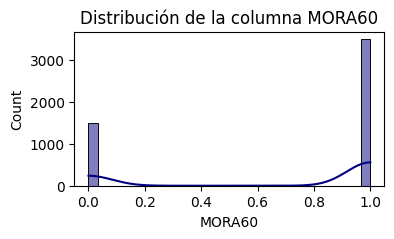

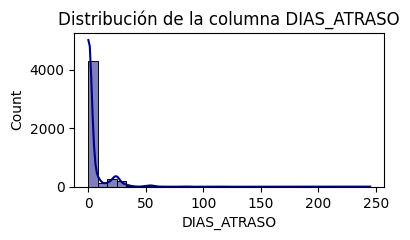

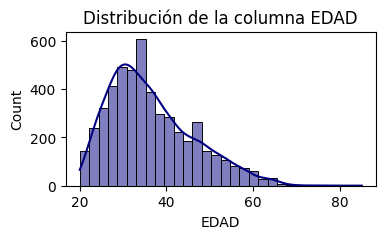

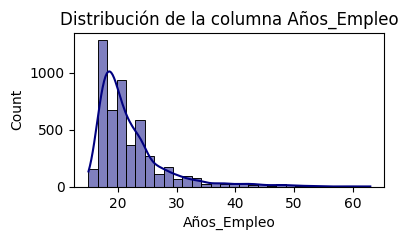

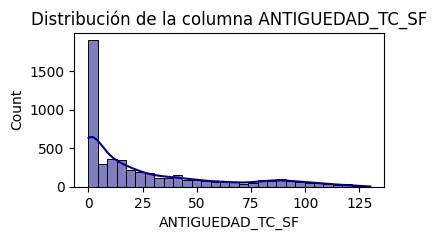

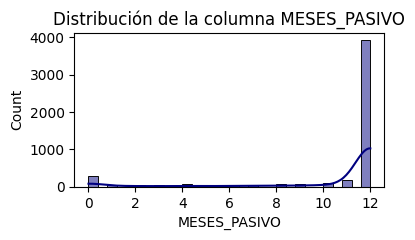

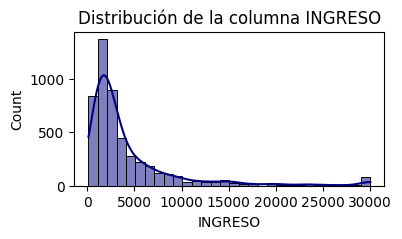

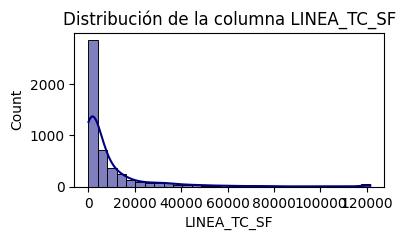

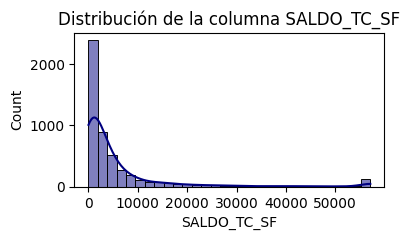

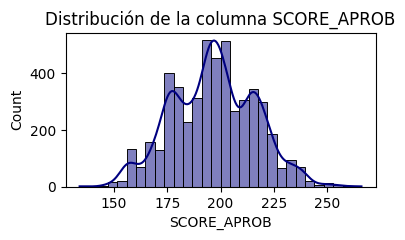

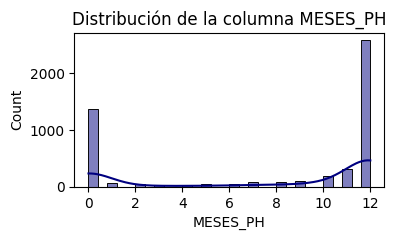

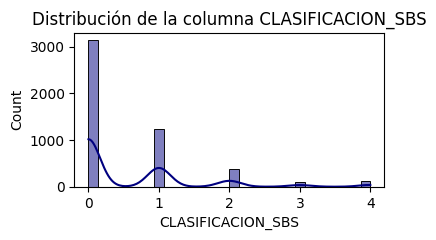

In [10]:
# Tabla de valores nulos
print("\nValores nulos por columna:")
print(data.isnull().sum())

# Análisis de distribución para variables numéricas
num_cols = data.select_dtypes(include=['float64', 'int64']).columns
for col in num_cols:
    plt.figure(figsize=(4, 2))
    sns.histplot(data[col].dropna(), kde=True, bins=30, color='navy')
    plt.title(f"Distribución de la columna {col}")
    plt.show()


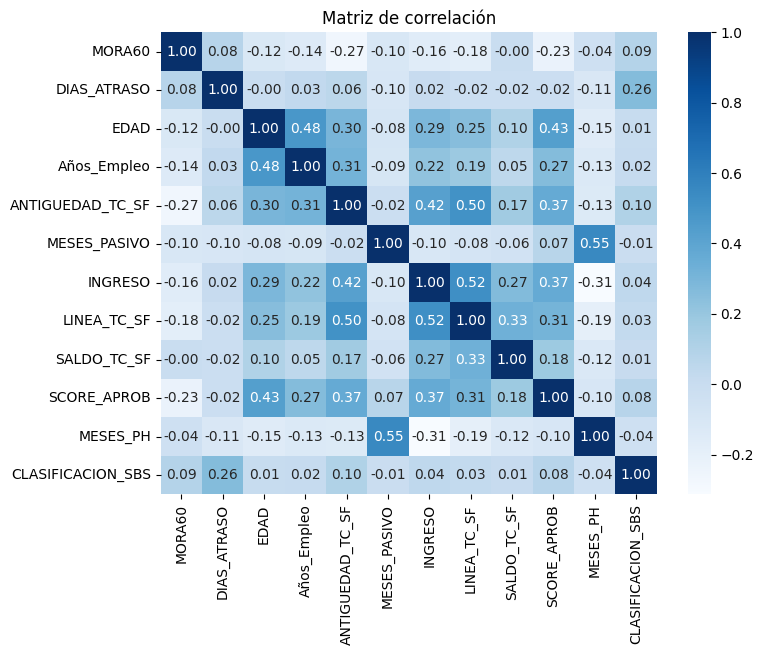

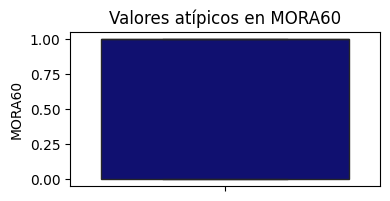

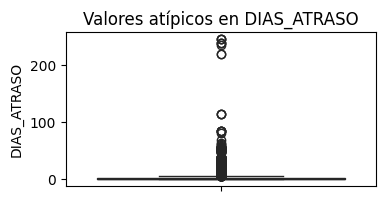

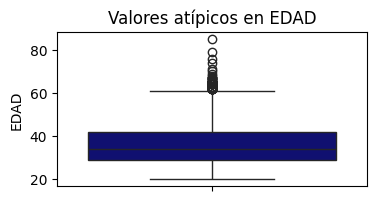

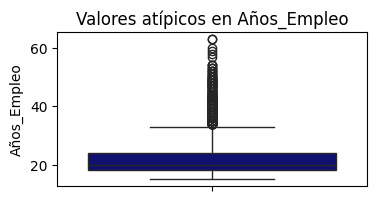

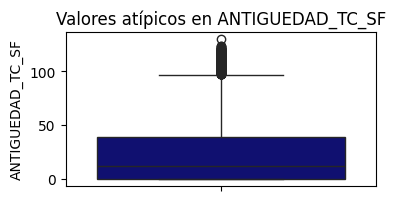

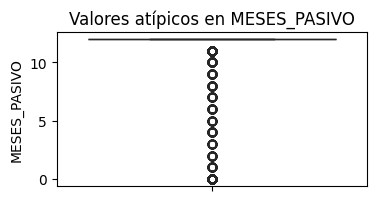

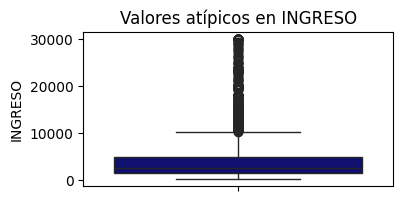

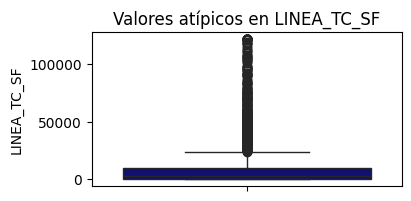

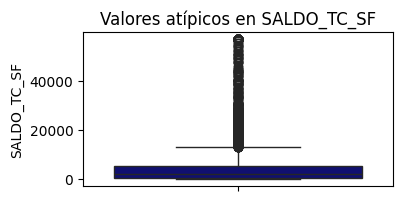

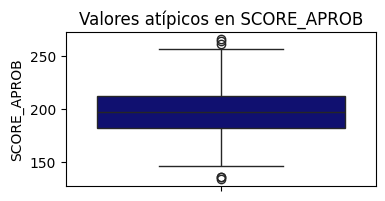

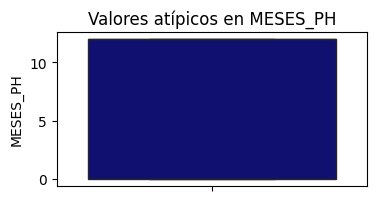

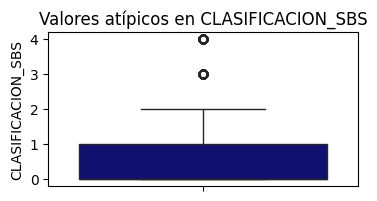

In [11]:
# Correlación
plt.figure(figsize=(8, 6))
correlation_matrix = data[num_cols].corr()
sns.heatmap(correlation_matrix, annot=True, cmap="Blues", fmt=".2f")
plt.title("Matriz de correlación")
plt.show()

# Gráficos de boxplot para identificar valores atípicos
for col in num_cols:
    plt.figure(figsize=(4, 2))
    sns.boxplot(data[col], color='navy')
    plt.title(f"Valores atípicos en {col}")
    plt.show()

In [40]:
# Crear rangos para columnas específicas
data['RNG_SCORE'] = pd.cut(data['SCORE_APROB'], bins=[-1, 160, 180, 200, 220, 240, 270],
                           labels=["<160", "160-180", "180-200", "200-220", "220-240", ">240"])


data['RNG_LINEA'] = pd.cut(data['LINEA_TC_SF'], bins=[-1,0, 1000, 3000, 6000, 10000, 1000000],
                           labels=["Sin Linea","<1000", "1000-3000", "3000-6000", "6000-10000", ">10000"])

data['RNG_ANTIGUEDAD'] = pd.cut(data['ANTIGUEDAD_TC_SF'], bins=[-1,1, 11,23, 47, 95, 1000000],
                           labels=["Sin Rango","1 a 11 meses", "12 a 23 meses", "24 a 47 meses", "48 a 95 meses", "mas de 96 meses"])

data['RNG_INGRESO'] = pd.cut(data['INGRESO'], bins=[0,930, 1200,2000, 3000, 6000, 10000000000],
                           labels=["<930", "930-1200", "1200-2000", "2000-3000", "3000-6000",">6000"])

data['RNG_AÑOS_EMPLEO'] = pd.cut(data['Años_Empleo'], bins=[0, 15,18, 19, 26],
                           labels=["<15", "15-18", "18-19", ">19"])

data['RNG_EDAD'] = pd.cut(data['EDAD'], bins=[0,25, 35,45, 60, 10000],
                           labels=["<25", "25-35", "35-45", "45-60", ">65"])

data['RNG_DIAS_ATRASO'] = pd.cut(data['DIAS_ATRASO'], bins=[-1,1, 16, 31,61, 1000],
                           labels=["Sin atraso", "1-15", "15-30", "30-60",">60"])

<ipython-input-41-27dd35fce74c>:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  agg_data = data.groupby(var).agg(
<ipython-input-41-27dd35fce74c>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=agg_data, x=var, y='Total_Monto', ax=ax1, palette='crest', alpha=0.7)


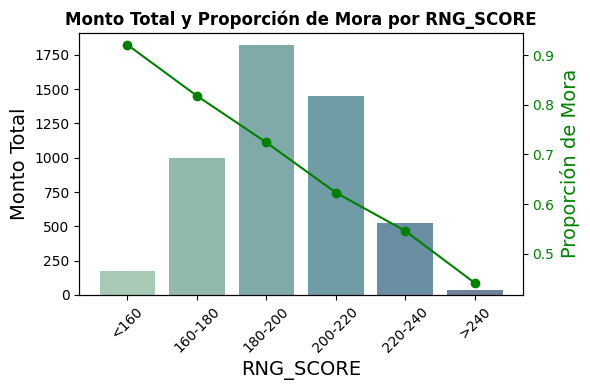

<ipython-input-41-27dd35fce74c>:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  agg_data = data.groupby(var).agg(
<ipython-input-41-27dd35fce74c>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=agg_data, x=var, y='Total_Monto', ax=ax1, palette='crest', alpha=0.7)


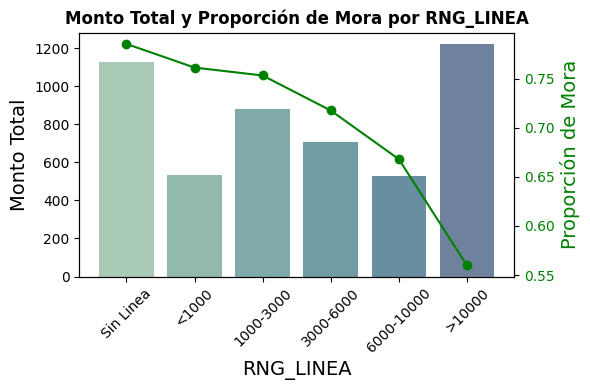

<ipython-input-41-27dd35fce74c>:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  agg_data = data.groupby(var).agg(
<ipython-input-41-27dd35fce74c>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=agg_data, x=var, y='Total_Monto', ax=ax1, palette='crest', alpha=0.7)


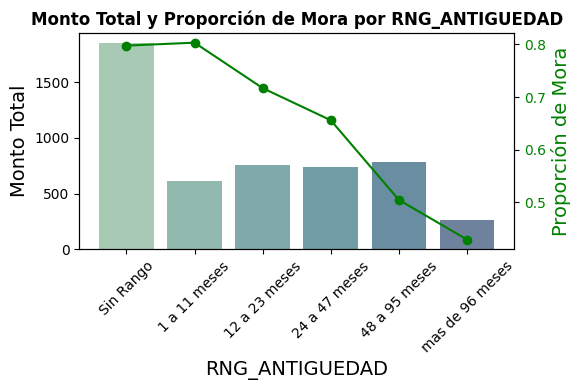

<ipython-input-41-27dd35fce74c>:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  agg_data = data.groupby(var).agg(
<ipython-input-41-27dd35fce74c>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=agg_data, x=var, y='Total_Monto', ax=ax1, palette='crest', alpha=0.7)


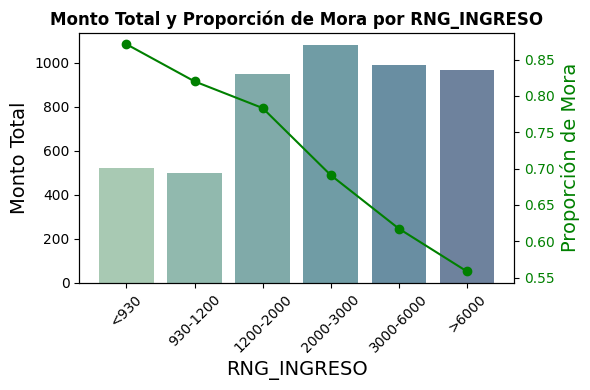

<ipython-input-41-27dd35fce74c>:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  agg_data = data.groupby(var).agg(
<ipython-input-41-27dd35fce74c>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=agg_data, x=var, y='Total_Monto', ax=ax1, palette='crest', alpha=0.7)


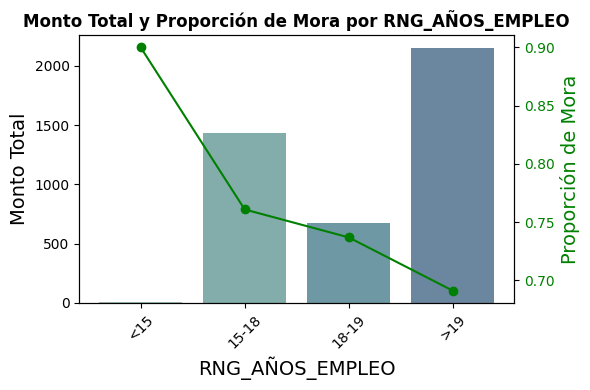

<ipython-input-41-27dd35fce74c>:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  agg_data = data.groupby(var).agg(
<ipython-input-41-27dd35fce74c>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=agg_data, x=var, y='Total_Monto', ax=ax1, palette='crest', alpha=0.7)


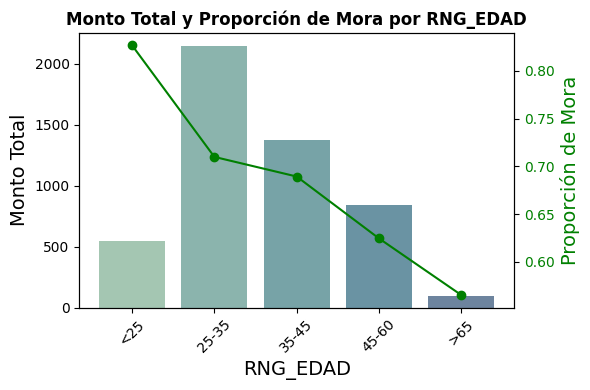

<ipython-input-41-27dd35fce74c>:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  agg_data = data.groupby(var).agg(
<ipython-input-41-27dd35fce74c>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=agg_data, x=var, y='Total_Monto', ax=ax1, palette='crest', alpha=0.7)


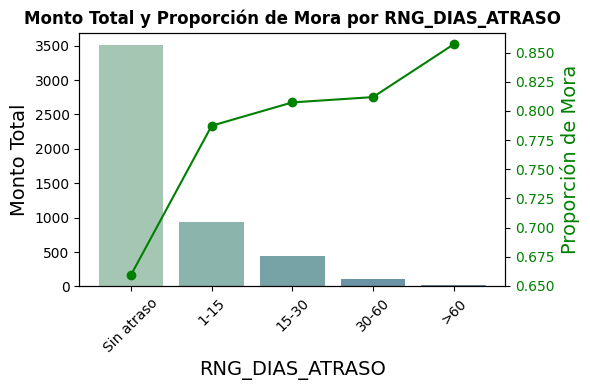

In [41]:

# Identificar las variables categóricas en el DataFrame
categorical_vars = data.select_dtypes(include=['category']).columns

# Iterar sobre las variables categóricas para graficar
for var in categorical_vars:
    # Agrupar datos por la variable categórica
    agg_data = data.groupby(var).agg(
        Total_Monto=(var, 'count'),
        Proporcion_Mora=('MORA60', 'mean')
    ).reset_index()

    # Crear el gráfico combinado
    fig, ax1 = plt.subplots(figsize=(6, 4))

    # Gráfico de barras para el monto
    sns.barplot(data=agg_data, x=var, y='Total_Monto', ax=ax1, palette='crest', alpha=0.7)
    ax1.set_xlabel(var, fontsize=14)
    ax1.set_ylabel('Monto Total', fontsize=14, color='black')
    ax1.tick_params(axis='y', labelcolor='black')
    ax1.set_title(f'Monto Total y Proporción de Mora por {var}', fontsize=12, fontweight='bold')
    plt.xticks(rotation=45)

    # Crear el eje secundario para la proporción de mora
    ax2 = ax1.twinx()
    ax2.plot(agg_data[var], agg_data['Proporcion_Mora'], color='green', marker='o', label='Mora')
    ax2.set_ylabel('Proporción de Mora', fontsize=14, color='green')
    ax2.tick_params(axis='y', labelcolor='green')

    # Ajustar y mostrar el gráfico
    fig.tight_layout()
    plt.show()

In [42]:
data.head()

,MORA60,DIAS_ATRASO,SITUACION_VIVIENDA,EDAD,Años_Empleo,ANTIGUEDAD_TC_SF,MESES_PASIVO,INGRESO,LINEA_TC_SF,SALDO_TC_SF,...,ZONA,CLASIFICACION_SBS,EDUCACION,RNG_SCORE,RNG_LINEA,RNG_ANTIGUEDAD,RNG_INGRESO,RNG_AÑOS_EMPLEO,RNG_EDAD,RNG_DIAS_ATRASO
0,0,235,FAMILIAR,30,17.0,93,5,3500.0,0.00,0.00,...,Lima,4,PROFESIONAL,200-220,Sin Linea,48 a 95 meses,3000-6000,15-18,25-35,>60
1,0,18,FAMILIAR,32,19.0,9,12,900.0,1824.67,1933.75,...,La Libertad,1,TECNICO,160-180,1000-3000,1 a 11 meses,<930,18-19,25-35,15-30
2,0,0,FAMILIAR,26,21.0,8,2,2400.0,2797.38,188.29,...,Lima,0,PROFESIONAL,180-200,1000-3000,1 a 11 meses,2000-3000,>19,25-35,Sin atraso
3,0,0,FAMILIAR,36,21.0,20,12,2700.0,0.00,0.00,...,Ancash,0,TECNICO,180-200,Sin Linea,12 a 23 meses,2000-3000,>19,35-45,Sin atraso
4,0,0,FAMILIAR,46,18.0,0,1,3100.0,2000.00,11010.65,...,Lima,0,TECNICO,180-200,1000-3000,Sin Rango,3000-6000,15-18,45-60,Sin atraso


In [54]:
# Verificar que las columnas existan en el DataFrame
selected_columns = ['MORA60', 'DIAS_ATRASO', 'SITUACION_VIVIENDA', 'EDAD', 'Años_Empleo','ANTIGUEDAD_TC_SF', 'MESES_PASIVO', 'INGRESO', 'LINEA_TC_SF',
       'SALDO_TC_SF', 'SCORE_APROB', 'MESES_PH', 'ZONA', 'CLASIFICACION_SBS','EDUCACION']

# Seleccionar columnas
data = data[selected_columns]

In [55]:
# Función para aplicar Target Encoding a variables categóricas
def target_encoding(df, categorical_cols, target_col):
    for col in categorical_cols:
        # Calcular la probabilidad condicional del target para cada categoría
        encoding_map = (
            df.groupby(col)[target_col]
            .mean()
            .to_dict()
        )
        # Reemplazar valores categóricos por su probabilidad condicional
        df[col] = df[col].map(encoding_map)
    return df

## Particion de la data para entrenar

In [56]:
# Identificar variables categóricas
categorical_cols = ["SITUACION_VIVIENDA", "ZONA", "EDUCACION"]

# Aplicar Target Encoding a las variables categóricas
data = target_encoding(data, categorical_cols, target_col="MORA60")

# Dividir en conjuntos de entrenamiento y prueba
X = data.drop("MORA60", axis=1)
y = data["MORA60"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123, stratify=y)

<ipython-input-55-7c0c8d96ece1>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].map(encoding_map)
<ipython-input-55-7c0c8d96ece1>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].map(encoding_map)
<ipython-input-55-7c0c8d96ece1>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

## Modelo Base: Regresion Logistica

In [57]:
# Medir el tiempo de entrenamiento
start_time = time.time()

# Entrenar el modelo de regresión logística
model = LogisticRegression(max_iter=1000, solver='liblinear')
model.fit(X_train, y_train)

end_time = time.time()
training_time = end_time - start_time

# Parámetros del modelo
coef_df = pd.DataFrame({"Variable": X.columns, "Coeficiente": model.coef_[0]})
print("Parámetros del modelo:")
print(coef_df)

# Predicciones de probabilidad
y_pred_prob = model.predict_proba(X_test)[:, 1]

# Cálculo del AUC
roc_auc = roc_auc_score(y_test, y_pred_prob)
print(f"AUC: {roc_auc:.4f}")

# Cálculo del coeficiente de Gini
gini = 2 * roc_auc - 1
print(f"Coeficiente de Gini: {gini:.4f}")

# Tiempo de entrenamiento
print(f"Tiempo de entrenamiento: {training_time:.4f} segundos")

Parámetros del modelo:
              Variable  Coeficiente
0          DIAS_ATRASO     0.010582
1   SITUACION_VIVIENDA     0.659229
2                 EDAD     0.005481
3          Años_Empleo    -0.014377
4     ANTIGUEDAD_TC_SF    -0.013891
5         MESES_PASIVO    -0.048167
6              INGRESO    -0.000020
7          LINEA_TC_SF    -0.000005
8          SALDO_TC_SF     0.000015
9          SCORE_APROB    -0.003456
10            MESES_PH    -0.022147
11                ZONA     0.945076
12   CLASIFICACION_SBS     0.267137
13           EDUCACION     0.925149
AUC: 0.7381
Coeficiente de Gini: 0.4761
Tiempo de entrenamiento: 0.1094 segundos


In [58]:
import xgboost as xgb
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score
import numpy as np

In [59]:
# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [60]:
# Convertir los datos a DMatrix (formato de XGBoost)
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Definir el modelo XGBoost
model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', use_label_encoder=False)

# Definir el espacio de parámetros a optimizar
param_dist = {
    'learning_rate': np.linspace(0.01, 0.3, 30),  # Tasa de aprendizaje
    'max_depth': [3, 4, 5, 6, 7, 8],              # Profundidad máxima de los árboles
    'n_estimators': [50, 100, 150, 200],          # Número de árboles (estimadores)
    'subsample': np.linspace(0.5, 1.0, 10),       # Proporción de muestras usadas para entrenar cada árbol
    'colsample_bytree': np.linspace(0.5, 1.0, 10), # Proporción de características usadas para cada árbol
    'gamma': [0, 0.1, 0.2, 0.3, 0.4],             # Regularización de la poda de árboles
    'alpha': [0, 0.1, 0.5, 1],                    # L1 regularization
    'lambda': [0, 0.1, 0.5, 1]                    # L2 regularization
}

# Inicializar el RandomizedSearchCV
random_search = RandomizedSearchCV(
    model,
    param_distributions=param_dist,
    n_iter=50,                  # Número de combinaciones aleatorias
    scoring='accuracy',         # Métrica de evaluación
    n_jobs=-1,                  # Usar todos los núcleos del CPU
    cv=5,                       # Validación cruzada de 5 pliegues
    verbose=1,                  # Ver progreso de búsqueda
    random_state=42
)

# Medir el tiempo de entrenamiento
start_time = time.time()

# Entrenar el modelo con la búsqueda de hiperparámetros
random_search.fit(X_train, y_train)

# Medir el tiempo transcurrido
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Tiempo de entrenamiento: {elapsed_time:.2f} segundos")

# Obtener los mejores parámetros encontrados
print(f"Mejores parámetros: {random_search.best_params_}")

# Evaluar el modelo en el conjunto de prueba
y_pred = random_search.best_estimator_.predict(X_test)
y_pred_proba = random_search.best_estimator_.predict_proba(X_test)[:, 1]  # Probabilidad de la clase positiva

# Calcular la precisión
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Calcular AUC
auc = roc_auc_score(y_test, y_pred_proba)
print(f"AUC: {auc:.4f}")

Fitting 5 folds for each of 50 candidates, totalling 250 fits


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:32:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Tiempo de entrenamiento: 74.75 segundos
Mejores parámetros: {'subsample': 0.5555555555555556, 'n_estimators': 200, 'max_depth': 4, 'learning_rate': 0.05999999999999999, 'lambda': 0.1, 'gamma': 0, 'colsample_bytree': 0.5555555555555556, 'alpha': 1}
Accuracy: 0.7373
AUC: 0.7336


In [98]:
# Calcular el Gini
gini = 2 * auc - 1
print(f"Gini: {gini:.4f}")

Gini: 0.4749


Tiempo de entrenamiento total: 1.21 segundos


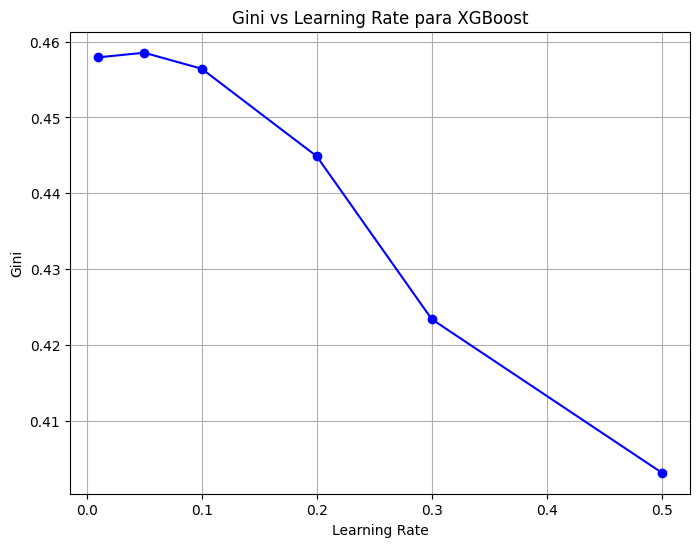

In [102]:
# Lista de learning rates a probar
learning_rates = [0.01, 0.05, 0.1, 0.2, 0.3, 0.5]

# Lista para almacenar los valores de Gini
gini_scores = []

# Medir el tiempo de entrenamiento
start_time = time.time()

for lr in learning_rates:
    # Definir el modelo XGBoost con el learning rate actual
    model = xgb.XGBClassifier(learning_rate=lr, n_estimators=100, random_state=42)

    # Entrenar el modelo
    model.fit(X_train, y_train)

    # Obtener las probabilidades predichas para la clase positiva (en este caso, 1)
    y_pred_prob = model.predict_proba(X_test)[:, 1]

    # Calcular AUC (Área bajo la curva ROC)
    auc = roc_auc_score(y_test, y_pred_prob)

    # Calcular el Gini
    gini = 2 * auc - 1
    gini_scores.append(gini)

# Medir el tiempo transcurrido
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Tiempo de entrenamiento total: {elapsed_time:.2f} segundos")

# Graficar Gini vs Learning Rate
plt.figure(figsize=(8, 6))
plt.plot(learning_rates, gini_scores, marker='o', linestyle='-', color='b')
plt.title('Gini vs Learning Rate para XGBoost')
plt.xlabel('Learning Rate')
plt.ylabel('Gini')
plt.grid(True)
plt.show()

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


[LightGBM] [Info] Number of positive: 2471, number of negative: 1029
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000925 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1199
[LightGBM] [Info] Number of data points in the train set: 3500, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.706000 -> initscore=0.876035
[LightGBM] [Info] Start training from score 0.876035
[LightGBM] [Info] Number of positive: 2471, number of negative: 1029
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000467 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1199
[LightGBM] [Info] Number of data points in the train set: 3500, number of used features: 16
[LightGBM] [Info] [binary:

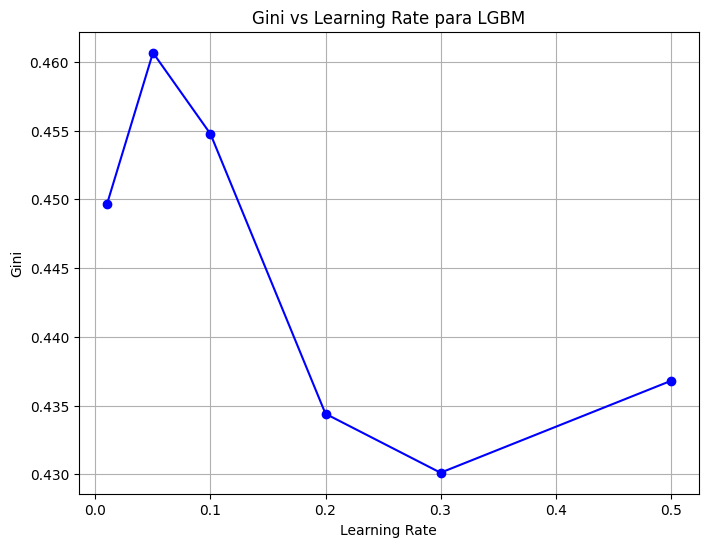

In [103]:
import lightgbm as lgb
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
import time

# Lista de learning rates a probar
learning_rates = [0.01, 0.05, 0.1, 0.2, 0.3, 0.5]

# Lista para almacenar los valores de Gini
gini_scores = []

# Medir el tiempo de entrenamiento
start_time = time.time()

for lr in learning_rates:
    # Definir el modelo LGBM con el learning rate actual
    model = lgb.LGBMClassifier(learning_rate=lr, n_estimators=100, random_state=42)

    # Entrenar el modelo
    model.fit(X_train, y_train)

    # Obtener las probabilidades predichas para la clase positiva (en este caso, 1)
    y_pred_prob = model.predict_proba(X_test)[:, 1]

    # Calcular AUC (Área bajo la curva ROC)
    auc = roc_auc_score(y_test, y_pred_prob)

    # Calcular el Gini
    gini = 2 * auc - 1
    gini_scores.append(gini)

# Medir el tiempo transcurrido
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Tiempo de entrenamiento total: {elapsed_time:.2f} segundos")

# Graficar Gini vs Learning Rate
plt.figure(figsize=(8, 6))
plt.plot(learning_rates, gini_scores, marker='o', linestyle='-', color='b')
plt.title('Gini vs Learning Rate para LGBM')
plt.xlabel('Learning Rate')
plt.ylabel('Gini')
plt.grid(True)
plt.show()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Tiempo de entrenamiento total: 21.79 segundos


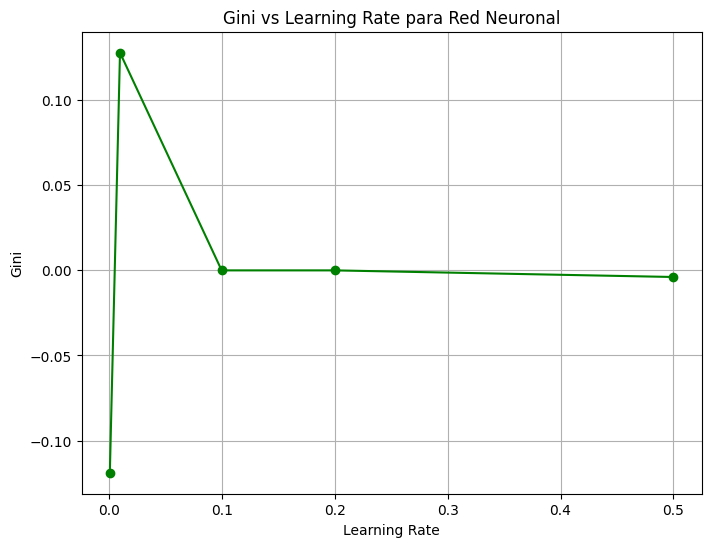

In [104]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import time

# Lista de learning rates a probar
learning_rates = [0.001, 0.01, 0.1, 0.2, 0.5]

# Lista para almacenar los valores de Gini
gini_scores = []

# Medir el tiempo de entrenamiento
start_time = time.time()

for lr in learning_rates:
    # Definir el modelo de red neuronal
    model = Sequential()
    model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))  # Salida para clasificación binaria

    # Compilar el modelo con el optimizador Adam y el learning rate especificado
    optimizer = Adam(learning_rate=lr)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    # Entrenar el modelo
    model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)

    # Obtener las probabilidades predichas para la clase positiva (en este caso, 1)
    y_pred_prob = model.predict(X_test)

    # Calcular AUC (Área bajo la curva ROC)
    auc = roc_auc_score(y_test, y_pred_prob)

    # Calcular el Gini
    gini = 2 * auc - 1
    gini_scores.append(gini)

# Medir el tiempo transcurrido
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Tiempo de entrenamiento total: {elapsed_time:.2f} segundos")

# Graficar Gini vs Learning Rate
plt.figure(figsize=(8, 6))
plt.plot(learning_rates, gini_scores, marker='o', linestyle='-', color='g')
plt.title('Gini vs Learning Rate para Red Neuronal')
plt.xlabel('Learning Rate')
plt.ylabel('Gini')
plt.grid(True)
plt.show()